In [283]:
############################################################################
# Name: Liam Navarre, Connor Deide
# Class: CPSC 322, Fall 2022
# Final Project
# 12/14/2022
#
# Description: This file contains an overview of our project and shows how
# we have prepared, used, and interpreted the data from our input files
############################################################################

In [284]:
import os
import math
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from project_application import project_utils
importlib.reload(project_utils)
from classifier_models import classifiers
importlib.reload(classifiers)
from classifier_models import classifier_utils
importlib.reload(classifier_utils)
from classifier_models import evaluators as eval
importlib.reload(eval)
from classifier_models.classifiers import MyDummyClassifier as Dummy_clf
from classifier_models.classifiers import MyKNeighborsClassifier as KNeighbors_clf
from classifier_models.classifiers import MyNaiveBayesClassifier as NaiveBayes_clf


# Introduction

In [285]:
# Read the data from file
the_office_data_1 = pd.read_csv('./data/the_office_series.csv')
the_office_data_2 = pd.read_csv('./data/the_office_episodes.csv')

# Remove unwanted attributes from the two tables
# From dataframe 1
the_office_data_1.pop("EpisodeTitle")
the_office_data_1.pop("Director")
the_office_data_1.pop("Writers")
# Want to descritize the about string into continuous values in the final project
the_office_data_1.pop("About")

# From dataframe 2
the_office_data_2.pop("Season")
the_office_data_2.pop("EpisodeNumInSeason")
the_office_data_2.pop("Title")
the_office_data_2.pop("OriginalAirDate")
the_office_data_2.pop("ProdCode")

# Join the data on the EpisodeNumOverall attribute
    # Serves as a unique id
the_office_data = pd.merge(the_office_data_1, the_office_data_2, on="EpisodeNumOverall", how="outer")
display(the_office_data)

,EpisodeNumOverall,Season,Ratings,Votes,Viewership,Duration,Date,GuestStars,DirectedBy,WrittenBy,USViewers
0,0,1,7.5,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,11200000.0
1,1,1,8.3,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak,6000000.0
2,2,1,7.8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein,5800000.0
3,3,1,8.1,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur,5400000.0
4,4,1,8.4,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...,...,...,...
183,183,9,8.0,1985,3.83,22,11 April 2013,NaN,Matt Sohn,Dan Sterling,3830000.0
184,184,9,8.0,2007,3.25,22,25 April 2013,NaN,Jesse Peretz,Halsted Sullivan & Warren Lieberstein,3250000.0
185,185,9,9.0,2831,3.51,42,2 May 2013,Michael Imperioli,Jeffrey Blitz,Niki Schwartz-Wright,3510000.0
186,186,9,9.5,3914,4.56,43,9 May 2013,NaN,David Rogers,Brent Forrester,4560000.0


# Clean Data
* We are attempting to predict the IMDb ratings value for unseen instances
    * This value is a floating point number with one decimal, resulting in many possible ratings values
    * This large variation greatly decreases the probability of predicting a correct rating value
    * To help increase the probability, we decided to round the ratings values into integers so a rating value can fall between 0 and 10
* Below this python block is a graph showing the frequency of our ratings values after rounding

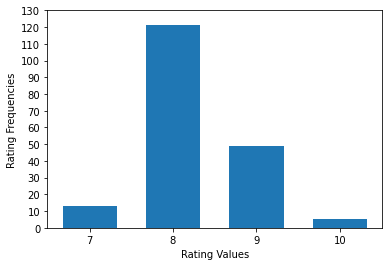

In [286]:
ratings_list = list(the_office_data.get("Ratings"))
round_ratings = []
for value in ratings_list:
    round_ratings.append(round(value))
# Replace Ratings column with rounded ratings
the_office_data["Ratings"] = round_ratings

ratings_freq = project_utils.get_instances(round_ratings)
# Prepare frequency data for matplotlib graph
xs = sorted(list(ratings_freq.keys()))
ys = []
for rating in xs:
    ys.append(ratings_freq[rating])
xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys) + 10, 10)

plt.xlabel("Rating Values")
plt.ylabel("Rating Frequencies")
plt.bar(xrng, ys, .65)
plt.xticks(xrng, xs)
plt.yticks(yrng)

plt.show()

## TO DO: Determine if we want to keep the guest stars as 0 and 1s

# Clean Data
* One more cleaning step is to modify the 'GuestStars' Column
    * The attribute value is left with a value 'N/A' if no guest star is present for that episode
* In order for our classifiers to better interpret this attribute, we will change the guest star domain to 1 or 0
    * This represents a true or false value, indicating whether there is a guest star in the episode or not

In [287]:
guest_stars_list = list(the_office_data.get("GuestStars"))
bool_guest_stars = []
for value in guest_stars_list:
    if type(value) != str:
        bool_guest_stars.append(0)
    else:
        bool_guest_stars.append(1)
# Replace Ratings column with rounded ratings
# the_office_data["GuestStars"] = bool_guest_stars
display(the_office_data)

,EpisodeNumOverall,Season,Ratings,Votes,Viewership,Duration,Date,GuestStars,DirectedBy,WrittenBy,USViewers
0,0,1,8,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais & Stephen Merchant and Greg Daniels,11200000.0
1,1,1,8,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak,6000000.0
2,2,1,8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein,5800000.0
3,3,1,8,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur,5400000.0
4,4,1,8,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels,5000000.0
...,...,...,...,...,...,...,...,...,...,...,...
183,183,9,8,1985,3.83,22,11 April 2013,NaN,Matt Sohn,Dan Sterling,3830000.0
184,184,9,8,2007,3.25,22,25 April 2013,NaN,Jesse Peretz,Halsted Sullivan & Warren Lieberstein,3250000.0
185,185,9,9,2831,3.51,42,2 May 2013,Michael Imperioli,Jeffrey Blitz,Niki Schwartz-Wright,3510000.0
186,186,9,10,3914,4.56,43,9 May 2013,NaN,David Rogers,Brent Forrester,4560000.0


# Getting Predictions
* To prove that we can get predictions from this dataset we will implement a Naive Bayes Classifier and use Stratified Cross Validation

In [288]:
# Extract and remove the Ratings column (y) from the dataframe
y = list(the_office_data.get("Ratings"))
the_office_data.pop("Ratings")
# Build X with the remaining data
X = the_office_data.values.tolist()

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 10)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 10)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 10)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Complete Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()


Naive Bayes Classifier Report With Complete Data Set
Naive Bayes Classifier: accuracy = 0.88, error rate = 0.12
Precision:  0
Recall:  0
F-1:  0



### Reflection 
We found our Precision, Recall, and F-1 score to be 0 when we give it the prediction of 10. This is because currently our precision, recall, and F-1 score work soley with binary classification. Our data set is classified into 4 categories so our binary scores will result in 1 or 0. If we were to give our most common prediction of 8, our score would result in 1. We also found a high accuracy of 88% when trying to gain predictions on the dataset. With an error rate of 12%, we are confident on our predictions based on 4 different categories

## Predictions Based on Different Attributes 

After finding our results when comparing against our entire cleaned dataset, we were interested in testing the accuracy based on certain attributes. We are curious to see if we can find a correlation to what attributes are "weighted" the most. We wanted to test against the Viewership, Guest Star, Director, Writer, Duration, and Votes Attributes. 

### Prediction Based on Viewership

In [289]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the viewership column from the dataframe
viewership = list(the_office_data.get("Viewership"))

# Build X with the remaining data
X = [[viewership[i]] for i in range(len(viewership))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Viewership Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()


Naive Bayes Classifier Report With Viewership Data Set
Naive Bayes Classifier: accuracy = 0.79, error rate = 0.21
Precision:  0.97
Recall:  0.91
F-1:  0.94



#### Reflection
We were able to receive an accuracy of 79% when testing the data based on the viewership attribute. This is still a strong accuracy rate but makes sense for there to be a higher error rate. There are plenty examples of shows or movies with a high viewership but a poor rating. We were able to produce precision, recall, and f-1 scores on this data set but they have no foundation in making predictions on four different categories. An interesting correlation can be noticed when trying different predictions of our data set in records to the precision, recall, and f-1 score. Although they are unbased, when our most common prediction of 8 was tested we received our highest scores. While when the least common prediciton of 10 had scores of 0. With the prediction of 9 recieving the second highest and 7 recieving our third highest. This correlates to the order of how common each prediction is. 

### Predictions Based On Guest Stars

In [290]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Guest Stars column from the dataframe
guest_stars = list(the_office_data.get("GuestStars"))

# Build X with the remaining data
X = [[guest_stars[i]] for i in range(len(guest_stars))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Guest Stars Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Guest Stars Data Set
Naive Bayes Classifier: accuracy = 0.66, error rate = 0.34
Precision:  0.66
Recall:  1.0
F-1:  0.8



#### Reflection
We were able to receive an accuracy score of 65% and an error rate of 35%. It makes sense for classifiers accuracy to be lower and error rate to be higher when soley basing the prediction on whether or not a guest star was present in the episode. A guest star can cause the content of the show to improve but a guest star can also take away from the core material of the episode. We were able to receive a precision, recall, and F-1 score for our most common prediction of 8 but 0 is returned when testing against the other predictions. Again this is due to our dinary precision scores not being prepared to handle four categories based on predictions

### Predictions Based On Director

In [291]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Directors column from the dataframe
directors = list(the_office_data.get("DirectedBy"))

# Build X with the remaining data
X = [[directors[i]] for i in range(len(directors))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Directors Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Directors Data Set
Naive Bayes Classifier: accuracy = 0.68, error rate = 0.32
Precision:  0.73
Recall:  0.91
F-1:  0.81



#### Reflection


### Predictions Based on Written By

In [292]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
writers = list(the_office_data.get("WrittenBy"))

# Build X with the remaining data
X = [[writers[i]] for i in range(len(writers))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Writers Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Writers Data Set
Naive Bayes Classifier: accuracy = 0.67, error rate = 0.33
Precision:  0.73
Recall:  0.9
F-1:  0.81



#### Reflection 
We were able to receive an accuracy of 67% and an error rate of 33%

### Predictions Based on Writers and Directors

In [293]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers and Directors columns from the dataframe
writers = list(the_office_data.get("WrittenBy"))
directors = list(the_office_data.get("DirectedBy"))

# Build X with the remaining data
X = [[directors[i], writers[i]]  for i in range(len(writers))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Writers and Directors Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Writers and Directors Data Set
Naive Bayes Classifier: accuracy = 0.78, error rate = 0.22
Precision:  0.88
Recall:  0.87
F-1:  0.87



#### Reflection
We were able to recieve an accuracy of 78% and an error rate of 22% when running the prediction on the writers and directors

### Predictions Based on Duration

In [294]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
duration = list(the_office_data.get("Duration"))

# Build X with the remaining data
X = [[duration[i]] for i in range(len(duration))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Duration Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Duration Data Set
Naive Bayes Classifier: accuracy = 0.69, error rate = 0.31
Precision:  0.71
Recall:  0.98
F-1:  0.82



#### Reflection 
We were able to receive an accuracy score of 69% and an error rate of 31% when predicting based on the episodes duration. 

### Predictions Based on Votes

In [295]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe
votes = list(the_office_data.get("Votes"))

# Build X with the remaining data
X = [[votes[i]] for i in range(len(votes))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Votes Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Votes Data Set
Naive Bayes Classifier: accuracy = 0.86, error rate = 0.14
Precision:  1.0
Recall:  0.98
F-1:  0.99



### Reflection 
We were able to receive an accuracy of 86% and an error rate of 14%

### Prediction Based on Most Weighted Attributes
After finding what attributes have the strongest affect on the accuracy of the prediction, we thought it would be prudent to run a prediction on those attributes. In this Accuracy model we will prediction against the Viewership, Votes, and Directed/WrittenBy attributes

In [296]:
# We retain the same Y from the previous Naive Bayes Classification

# Extract the Writers column from the dataframe

votes = list(the_office_data.get("Votes"))
viewership = list(the_office_data.get("Viewership"))
writers = list(the_office_data.get("WrittenBy"))
guest_stars = list(the_office_data.get("GuestStars"))
directors = list(the_office_data.get("DirectedBy"))

# Build X with the remaining data
X = [[votes[i], viewership[i], directors[i], writers[i]] for i in range(len(votes))]

# Naive Bayes Classification
# Use utility functions to compute the desired values
naive_accuracy, naive_error_rate, naive_y_true, naive_y_pred = project_utils.cross_val_predict(\
    X, y, eval, NaiveBayes_clf(), True)
naive_precision = eval.binary_precision_score(naive_y_true, naive_y_pred, None, 8)
naive_recall = eval.binary_recall_score(naive_y_true, naive_y_pred, None, 8)
naive_f_one = eval.binary_f1_score(naive_y_true, naive_y_pred, None, 8)

# Print the values found
print("===================================================")
print("Naive Bayes Classifier Report With Most Weighted Data Set")
print("===================================================")
print("Naive Bayes Classifier: accuracy = "\
    + str(naive_accuracy) + ", error rate = " + str(naive_error_rate))
print("Precision: ", round(naive_precision, 2))
print("Recall: ", round(naive_recall, 2))
print("F-1: ", round(naive_f_one, 2))
print()

Naive Bayes Classifier Report With Most Weighted Data Set
Naive Bayes Classifier: accuracy = 0.88, error rate = 0.12
Precision:  1.0
Recall:  1.0
F-1:  1.0



#### Reflection
We were able to recieve an accuracy of 88% and an error rate of 12%. This shows we were able to get rid of attributes that little to no affect on the accuracy of the classifier. We ran the same prediction while including the GuestStars column and recieved the same prediction accuracy. This informs us that the Votes, Viewership, DirectedBy, and WrittenBy columns are the most important attributes to make predictions on 

188


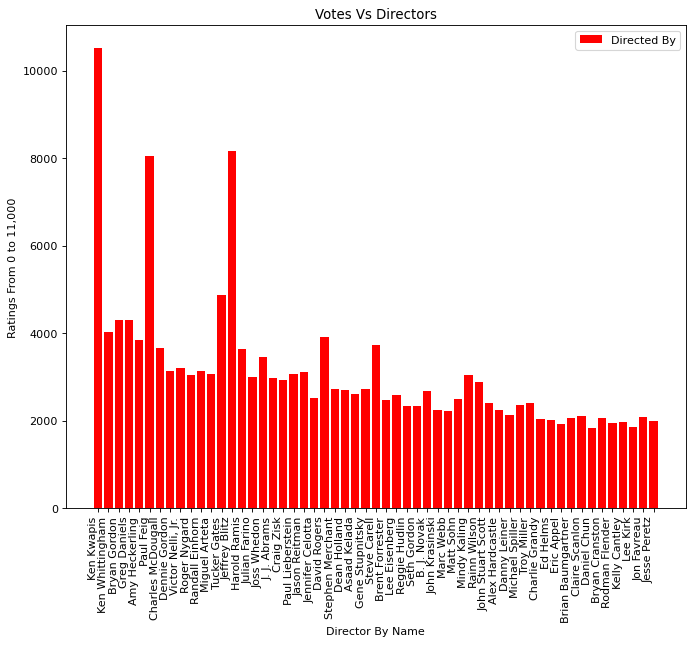

In [298]:

writer_director = []

plt.figure(figsize=(10,8), dpi=80)
for i in range(len(votes)):
    writer_director.append(writers[i] + " " + directors[i])
print(len(votes))
plt.bar(directors, votes, color='red', label="Directed By")
plt.title("Votes Vs Directors")
plt.xlabel("Director By Name")
plt.ylabel("Ratings From 0 to 11,000")
plt.legend(loc = 1)
plt.xticks(rotation=90, ha='right') 
plt.show()